# Build your own CNN on Cifar10 image data

In this demo, you will learn to:

* load cifer10 dataset from keras and visualize the images.
* process the data and convert class vectors to binary one-hot matrices
* build CNN to train and test on a small subset of cifar10 data
* see the effect of dropout and batch normalization
* perform data augmentation for smaller datasets



The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) is a collection of 60,000 color, 32x32-pixel images in ten classes. Classes include common objects such as airplanes, automobiles, birds, cats and so on. There are 50,000 train and 10,000 test images. Keras can automatically download the dataset from `keras.datasets`. Note that it will take some time to downloading the dataset for the first time. But, the download will be saved in cache and would not be needed to download again. 

State of the art results are achieved using very large Convolutional Neural networks. Model performance is reported in [classification accuracy](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130), with state-of-the-art results at 96.5% with human performance on the problem at 94%.

Most of the code and the description in this demo is taken from cifar10_cnn.py available at [keras-team Github page](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) as well as from the tutorial page by [Jason Brownlee](https://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/).


## Start with loading basic packages

You may need to install pillow using `pip install pillow`. It is used by scipy.misc.toimage to convert the data into an image for displaying.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.datasets import cifar10
from matplotlib import pyplot
from scipy import misc

Using TensorFlow backend.


Create a 3×3 plot of photographs. The images have been scaled up from their small 32×32 size, but you can clearly see trucks horses and cars. You can also see some distortion in some images that have been forced to the square aspect ratio.

In [2]:
# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

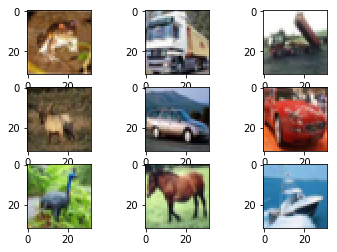

In [3]:
# create a grid of 3x3 images
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(misc.toimage(x_train[i]))
# show the plot
pyplot.show()

import some more packages for building CNN model and saving the trained model

In [4]:
from __future__ import print_function
# from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model #save and load models
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization


As is good practice, we next initialize the random number seed with a constant to ensure the results are reproducible.

In [5]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

## Preprocess the data 

The pixel values are in the range of 0 to 255 for each of the red, green and blue channels.

It is good practice to work with normalized data. Because the input values are well understood, we can easily normalize to the range 0 to 1 by dividing each value by the maximum observation which is 255.

Note, the data is loaded as integers, so we must cast it to floating point values in order to perform the division.

In [6]:
# The data, split between train and test sets:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
x_train = X_train[:1000,:,:,:]
x_test = X_test[:1000,:,:,:]
y_train = Y_train[:1000]
y_test = Y_test[:1000]
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# normalize inputs from 0-255 to 0.0-1.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


x_train shape: (1000, 32, 32, 3)
1000 train samples
1000 test samples


## Apply one-hot coding to labels
The output variables are defined as a vector of integers from 0 to 1 for each class.

We can use a one hot encoding to transform them into a binary matrix in order to best model the classification problem. We know there are 10 classes for this problem, so we can expect the binary matrix to have a width of 10.

In [7]:
# Convert class vectors to binary class matrices.
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('Number of classes:', y_train.shape[1])

Number of classes: 10


## Building a Simple CNN model

Let’s start off by defining a simple CNN structure as a baseline and evaluate how well it performs on the problem.

We will use a structure with two convolutional layers each followed by max pooling and a flattening out of the network to fully connected layers to make predictions.

Start with defining the important parameters

In [8]:
batch_size = 32
epochs = 20
lrate = 0.05
decay = lrate/epochs
#save_dir = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'keras_cifar10_trained_model.h5'

In [9]:
import keras.backend as K

### Build the basic CNN model

Our baseline network structure can be summarized as follows:

* First convolutional layer that converts the input image to 32 feature maps with a kernel size of 3×3, and a rectifier (ReLU) activation function, followed by Max Pooling.
* Second convolutional layer 
* Flatten layer.
* Fully connected layer with 512 units and a rectifier activation function.
* Fully connected output layer with 10 units and a softmax activation function.

In [10]:
K.clear_session()
model = Sequential()
model.add(Conv2D(32, (3, 3), 
                 padding='valid', 
                 input_shape=x_train.shape[1:],
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

### Choose the optimizer and compile the model
We use a logarithmic loss function `categorical_crossentropy` and optimize it using `adam` optimizer.

In [11]:
# initiate Adam optimizer
opt = keras.optimizers.adam(lr=lrate, decay=decay)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               590336    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total para

### Fit the model on training data
We can fit this model with 20 epochs and a batch size of 32.

A small number of epochs was chosen to help keep this demo moving. Normally the number of epochs would be much larger (say 10,000) for this problem.

Once the model is fit, we evaluate it on the test dataset and print out the classification accuracy.

In [12]:
# Fit the model
np.random.seed(seed)
hist_basic = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

print('Done!')

Train on 1000 samples, validate on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 2s 2ms/step - loss: 14.1873 - acc: 0.0950 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/20
1000/1000 [==============================] - 2s 2ms/step - loss: 14.5224 - acc: 0.0990 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/20
1000/1000 [==============================] - 2s 2ms/step - loss: 14.5224 - acc: 0.0990 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/20
1000/1000 [==============================] - 2s 2ms/step - loss: 14.5224 - acc: 0.0990 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/20
1000/1000 [==============================] - 2s 2ms/step - loss: 14.5224 - acc: 0.0990 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/20
1000/1000 [==============================] - 2s 2ms/step - loss: 14.5224 - acc: 0.0990 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/20
1000/1000 [==============================] - 2s 2ms/step - loss: 14.5224 - acc: 0.0990 - val_loss: 14.5063 - val_acc: 0.1000


Save and load the model

In [13]:
model.save("cifar_basic.h5")
model = load_model("cifar_basic.h5")

## Build model with batch normalization

Batch normalization speed-up the learning. The `BatchNormalization` in keras applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. We add a batch normalization layer before each new layer. 

The model architecture can be summarized as

* Convolutional input layer, 32 feature maps with a size of 3×3, and a rectifier (ReLU) activation function.
* Batch normalization to normalize the input for the next layer
* Convolutional layer, 32 feature maps with a size of 3×3, and a rectifier activation function. 
* Max Pool layer with size 2×2.
* Flatten layer.
* Batch normalization to normalize the input for the next layer
* Fully connected layer with 512 units and a rectifier activation function.
* Batch normalization to normalize the input for the next layer
* Fully connected output layer with 10 units and a softmax activation function.


In [14]:
K.clear_session()

model = Sequential()

model.add(Conv2D(32, (3, 3), 
                 padding='valid', activation='relu',
                 input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# initiate Adam optimizer
opt = keras.optimizers.adam(lr=lrate, decay=decay)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1152)              4608      
__________

### Fit and evaluate the model with batch normalization
We will see that the training performs significantly better with batch normalization.

In [15]:
print('Using batch normalization but no dropout and no data augmentation.')
# Fit the model


np.random.seed(seed)
epochs=20
hist_bn = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

#Save the model
model.save("cifar_bn.h5")
model = load_model("cifar_bn.h5")


Using batch normalization but no dropout and no data augmentation.
Train on 1000 samples, validate on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 3s 3ms/step - loss: 5.9393 - acc: 0.1910 - val_loss: 13.1614 - val_acc: 0.1270
Epoch 2/20
1000/1000 [==============================] - 3s 3ms/step - loss: 2.8365 - acc: 0.2380 - val_loss: 7.8267 - val_acc: 0.1430
Epoch 3/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.9880 - acc: 0.3170 - val_loss: 3.0005 - val_acc: 0.2510
Epoch 4/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.8951 - acc: 0.3340 - val_loss: 3.3790 - val_acc: 0.2070
Epoch 5/20
1000/1000 [==============================] - 2s 2ms/step - loss: 1.7150 - acc: 0.3990 - val_loss: 2.5962 - val_acc: 0.2180
Epoch 6/20
1000/1000 [==============================] - 2s 2ms/step - loss: 1.6863 - acc: 0.4010 - val_loss: 2.5768 - val_acc: 0.2600
Epoch 7/20
1000/1000 [==============================] - 2s 2ms/step - loss: 1.64

## Dropout and Batch normalization

Dropout is a way to avoid overfitting. It allows the network to train a subset of nodes in each epoch.

Here we copy the model with batch normalization, except we add dropout after batch normalization, to indicate that the next layer will be trained with dropout.  

In [16]:
K.clear_session()

model = Sequential()

# no need for normalization as the input is normalized
model.add(Conv2D(32, (3, 3), 
                 padding='valid', activation='relu',
                 input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# initiate Adam optimizer
opt = keras.optimizers.adam(lr=lrate, decay=decay)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

### Fit and evaluate the model with dropout

Note that with dropout you should increase the number of epochs to obtain similar results as without dropout. It is possible with more epochs we can further improve the validation accuracy.


In [17]:
print('Using batch normalization and dropout.')
# Fit the model

epochs = 20

np.random.seed(seed)
hist_dropout = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

#Save the model
model.save("cifar_dropout.h5")
model = load_model("cifar_dropout.h5")



Using batch normalization and dropout.
Train on 1000 samples, validate on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 3s 3ms/step - loss: 7.3619 - acc: 0.2030 - val_loss: 11.9707 - val_acc: 0.1520
Epoch 2/20
1000/1000 [==============================] - 2s 2ms/step - loss: 6.8575 - acc: 0.2140 - val_loss: 12.7032 - val_acc: 0.1380
Epoch 3/20
1000/1000 [==============================] - 2s 2ms/step - loss: 4.2219 - acc: 0.2480 - val_loss: 5.6387 - val_acc: 0.1470
Epoch 4/20
1000/1000 [==============================] - 3s 3ms/step - loss: 3.4606 - acc: 0.2160 - val_loss: 4.2175 - val_acc: 0.1270
Epoch 5/20
1000/1000 [==============================] - 2s 2ms/step - loss: 2.7394 - acc: 0.2430 - val_loss: 3.3213 - val_acc: 0.1630
Epoch 6/20
1000/1000 [==============================] - 2s 2ms/step - loss: 2.3953 - acc: 0.2550 - val_loss: 2.2307 - val_acc: 0.2950
Epoch 7/20
1000/1000 [==============================] - 2s 2ms/step - loss: 2.1923 - acc: 0.2940 - val_loss

## Data Augmentation

Data augmentation is used to build a powerful image classifier using only very few training examples.
A tutorial for [building image classification models using very little data](
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) is helpful.


### First Build the model
We use the same model as we developed earlier.

In [18]:
K.clear_session()

model = Sequential()

# no need for normalization as the input is normalized
model.add(Conv2D(32, (3, 3), 
                 padding='valid', activation='relu',
                 input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# initiate Adam optimizer
opt = keras.optimizers.adam(lr=lrate, decay=decay)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

### Using real-time data augmentation

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class. This class allows you to configure random transformations and normalization operations to be done on your image data during training.



In [19]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)
epochs = 20
np.random.seed(seed)

# Fit the model on the batches generated by datagen.flow().
hist_dataAug = model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4)

#Save the model
model.save("cifar_dataAug.h5")
model = load_model("cifar_dataAug.h5")
    

Using real-time data augmentation.
Epoch 1/20
32/32 [==============================] - 3s 109ms/step - loss: 7.7340 - acc: 0.1748 - val_loss: 10.0633 - val_acc: 0.1810
Epoch 2/20
32/32 [==============================] - 2s 60ms/step - loss: 6.6555 - acc: 0.2062 - val_loss: 11.3602 - val_acc: 0.1540
Epoch 3/20
32/32 [==============================] - 2s 70ms/step - loss: 4.3481 - acc: 0.2110 - val_loss: 3.3347 - val_acc: 0.1290
Epoch 4/20
32/32 [==============================] - 2s 68ms/step - loss: 3.4786 - acc: 0.2002 - val_loss: 3.4387 - val_acc: 0.1610
Epoch 5/20
32/32 [==============================] - 2s 66ms/step - loss: 2.9784 - acc: 0.2042 - val_loss: 3.7877 - val_acc: 0.1220
Epoch 6/20
32/32 [==============================] - 2s 60ms/step - loss: 2.5402 - acc: 0.2411 - val_loss: 3.0473 - val_acc: 0.1740
Epoch 7/20
32/32 [==============================] - 2s 60ms/step - loss: 2.4903 - acc: 0.2402 - val_loss: 2.4575 - val_acc: 0.2160
Epoch 8/20
32/32 [===========================

## Plot the training and validation accuracy with different training procedures

We see that with all methods (except the basic procedure) the training accuracy generally increases with epochs, but the validation accuracy fluctuates. This is in part because we have a relatively small training and validation set. Using batch normalization can significant improve the training performance, adding dropout can actually decrease the training performance. But but using droput help to improve the validation accuracy.  In our setup, data augmentation did not help.

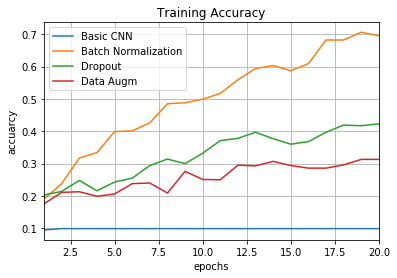

In [20]:
epochsn=np.arange(1,21)
plt.plot(epochsn,hist_basic.history['acc'])
plt.plot(epochsn,hist_bn.history['acc'])
plt.plot(epochsn,hist_dropout.history['acc'])
plt.plot(epochsn,hist_dataAug.history['acc'])
plt.xlim((1,20))

plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.title('Training Accuracy')
plt.legend(['Basic CNN', 'Batch Normalization', 'Dropout', 'Data Augm'])

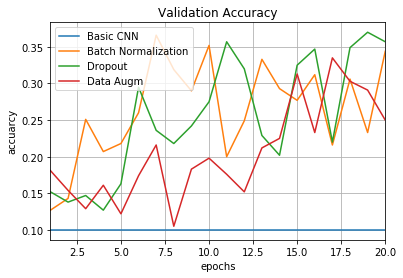

In [21]:
plt.plot(epochsn,hist_basic.history['val_acc'])
plt.plot(epochsn,hist_bn.history['val_acc'])
plt.plot(epochsn,hist_dropout.history['val_acc'])
plt.plot(epochsn,hist_dataAug.history['val_acc'])
plt.xlim((1,20))
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.title('Validation Accuracy')
plt.legend(['Basic CNN', 'Batch Normalization', 'Dropout', 'Data Augm'])

In [22]:
model = load_model("cifar_dropout.h5")
yhat = model.predict(x_test[:11])

# print('true label', y_test[:11])
# print('predicted label', yhat)


print('true label', np.argmax(y_test[:11],1))

print('predicted label', np.argmax(yhat,1))


true label [3 8 8 0 6 6 1 6 3 1 0]
predicted label [6 9 8 8 6 6 1 2 2 8 0]


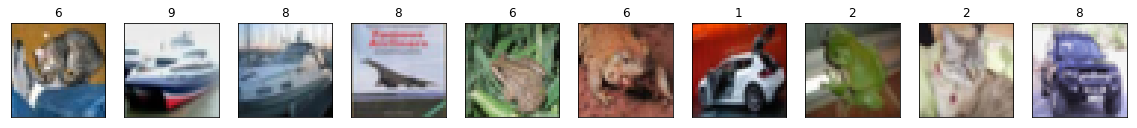

In [23]:
nplot = 10
plt.figure(figsize=(20,20))
for i in range(nplot):
    plt.subplot(1,nplot,i+1)
    plt.imshow(x_test[i,:,:,:])
    plt.title(int(np.argmax(yhat[i])))
    plt.xticks([])
    plt.yticks([])